In [1]:
# Imports
import os

# import methods from FIA python script
from FIA import *

oms.LogConfigHandler().setLogLevel("DEBUG")

## Loading

In [2]:
# set path to your mzML files and workfolder
data_dir = "../../data/example data/exampleA_ecolistrains"
run_dir = "../../runs/fia_explorer"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
fia_df = load_fia_df(data_dir, ".mzXML")

Loading experiments:


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Loading names:


100%|██████████| 6/6 [00:00<?, ?it/s]


## Initial Centroiding

In [4]:
"""
fia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="Orbitrap",                                      # For All
                                                                                                signal_to_noise=1.0, spacing_difference=1.5,                        
                                                                                                spacing_difference_gap=4.0, missing=1, ms_levels=[1],                   # For Orbitrap
                                                                                                report_FWHM="true", report_FWHM_unit="relative", max_intensity=-1,
                                                                                                auto_max_stdev_factor=3.0, auto_max_percentile=95, auto_mode=0,
                                                                                                win_len=200.0, bin_count=30, min_required_elements=10, 
                                                                                                noise_for_empty_window=1e+20, write_log_messages="true",            
                                                                                                peak_width=0.0, sn_bin_count=30, nr_iterations=5, sn_win_len=20.0,      # For TOF
                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",
                                                                                                deepcopy=False))
"""
# centroid_dir = os.path.join(run_dir, "centroids")

'\nfia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="Orbitrap",                                      # For All\n                                                                                                signal_to_noise=1.0, spacing_difference=1.5,                        \n                                                                                                spacing_difference_gap=4.0, missing=1, ms_levels=[1],                   # For Orbitrap\n                                                                                                report_FWHM="true", report_FWHM_unit="relative", max_intensity=-1,\n                                                                                                auto_max_stdev_factor=3.0, auto_max_percentile=95, auto_mode=0,\n                                                                                                win_len=200.0, bin_count=30, min_required_element

## Data pruning & binning

In [5]:
# Computes mean, media or sum of binned peaks (median needs ~2* more time)
fia_df["sum_experiment"] = fia_df["experiment"].apply(lambda experiment: limit_experiment(experiment, 51, 1699, 2*10**6, statistic="sum", deepcopy=True))

## Combining 

In [6]:
# merge_dir = merge_batch(centroid_dir, run_dir, block_size=None, mz_binning_width=5.0, mz_binning_width_unit="ppm", average_gaussian_cutoff=0.01, file_ending=".mzML")
# merge_dir = os.path.join(run_dir, "merged")

In [7]:
fia_df["comb_spectrum"] = fia_df["sum_experiment"].apply(lambda experiment: combine_spectra(experiment)) # type: ignore

In [8]:
s = fia_df["comb_spectrum"][0]
pd.DataFrame(np.array(s.get_peaks()).transpose(), columns=["mz", "intensity"])

,mz,intensity
0,51.000412,3082.0
1,51.001236,3840.0
2,51.002060,4243.0
3,51.002884,3719.0
4,51.003708,4018.0
...,...,...
1999995,1698.996292,882.0
1999996,1698.997116,4873.0
1999997,1698.997940,1555.0
1999998,1698.998764,1955.0


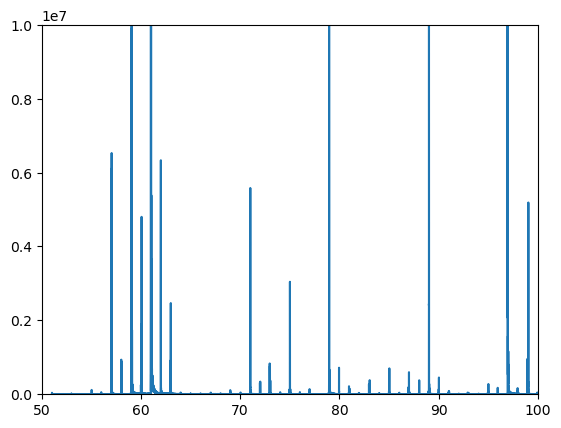

In [9]:
quick_plot(fia_df["comb_spectrum"][0], xlim=[50,100], ylim=[-1, 10000000], plottype="line")

## Clustering

In [10]:
np.stack(fia_df["comb_spectrum"][0].get_peaks(), axis=-1)

array([[  51.000412, 3082.      ],
       [  51.001236, 3840.      ],
       [  51.00206 , 4243.      ],
       ...,
       [1698.99794 , 1555.      ],
       [1698.998764, 1955.      ],
       [1698.999588, 2783.      ]])

In [11]:
from sklearn.cluster import *

In [12]:
sc = SpectralClustering(n_clusters=100, eigen_solver="amg", n_components=None, random_state=None, n_init=10, gamma=1.0,
                        affinity='rbf', n_neighbors=10, eigen_tol='auto', assign_labels='cluster_qr', degree=3, coef0=1, 
                        kernel_params=None, n_jobs=None, verbose=False)
cluster = sc.fit(np.stack(fia_df["comb_spectrum"][0].get_peaks(), axis=-1)[0:1000])

c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:411: UserWarning: Exited at iteration 854 with accuracies 
[1.84160305e-07 1.56172943e-07 1.62416687e-07 1.55450887e-07
 1.39098387e-07 1.39881977e-07 1.79596891e-07 1.52571762e-07
 1.47517382e-07 2.12371571e-07 2.45569328e-07 2.81271154e-07
 2.18647444e-07 2.94085902e-07 3.15110610e-07 4.94767106e-07
 4.18025607e-07 3.57586935e-07 6.58781670e-07 8.92655970e-07
 4.08826088e-07 7.10566446e-07 3.81532614e-07 7.26470636e-07
 6.15836777e-07 6.55429301e-07 5.62864121e-07 9.90829111e-07
 1.12524584e-06 1.29187430e-06 1.37206139e-06 8.91568067e-07
 1.25638488e-06 5.18160389e-07 2.02897415e-06 8.79500791e-07
 8.65444671e-07 3.34961584e-06 1.63548382e-06 1.98481612e-06
 1.52166416e-06 1.96033

In [13]:
cluster.labels_

array([15, 42, 88, 64, 36, 43, 58, 78, 59, 43,  7, 11, 50,  2,  2, 46, 65,
       60,  3, 64,  4, 31, 48, 24, 57, 74,  4,  6,  9,  3,  9,  3, 10, 16,
       92,  8,  6,  0, 90, 64, 97, 91, 61, 70, 33, 96, 83, 45, 32, 35,  3,
       83, 64, 87, 74, 90, 90, 96, 37, 68,  0, 77, 63, 77, 90, 73, 39, 47,
       22, 14, 32, 74, 58,  3, 10,  6, 61, 56, 56,  1, 81, 40, 70,  2, 65,
       78, 93, 44, 36,  9, 67, 88, 83, 31, 49,  2, 36, 91, 78,  3, 46, 80,
       48, 52, 61, 35, 42, 68, 18, 83, 69, 92, 61, 24, 88, 67, 81, 31, 10,
       65, 98,  6,  7, 60, 98,  7, 34, 87, 58, 74, 82,  2, 77, 61, 20,  1,
       33,  5, 61, 89,  6, 90,  4, 77, 92, 71, 78, 92, 66, 18, 96,  6, 77,
       85, 39, 54, 30, 91,  9, 39, 83, 19, 44, 97, 71, 92, 51, 82, 26, 82,
       66, 65, 13, 90, 61, 93, 58, 71, 59,  9, 35, 97, 46, 39, 98, 90, 10,
       63,  1, 30, 20, 42, 98, 44, 49, 59, 37, 34, 60, 87, 51, 37, 53, 39,
       68, 58, 30, 33, 18, 44, 68, 66, 73, 60,  0, 34, 84, 39, 35, 49, 95,
       34,  1, 56, 71, 59

<Axes: >

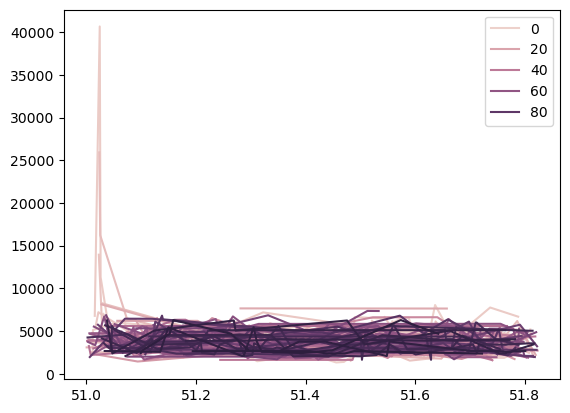

In [14]:
sns.lineplot(x=fia_df["comb_spectrum"][0].get_peaks()[0][0:1000], y=fia_df["comb_spectrum"][0].get_peaks()[1][0:1000], hue=cluster.labels_, sizes=(40, 40))

In [15]:
## Itertools
from itertools import combinations

In [16]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import single, fcluster, complete, complete, dendrogram

In [17]:
a = [1,2,3]
b = [1,2,6]
c = [10,11,12]
d = [10, 20, 30]
pdist([ [1, 10],  [11, 100], [2, 10], [2, 11]], metric="correlation")

array([0., 0., 0., 0., 0., 0.])

In [18]:
mzs, intensities = fia_df["comb_spectrum"][0].get_peaks()
mzs

array([  51.000412,   51.001236,   51.00206 , ..., 1698.99794 ,
       1698.998764, 1698.999588])

In [19]:
distances = pdist(mzs, metric="euclidean") * pdist(intensities, metric="correlation")

ValueError: A 2-dimensional array must be passed.

In [ ]:
cluster = complete(distances)

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'dcoord': [[0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.6026402928804868, 0.6026402928804868, 0.0]],
 'ivl': ['1', '3', '0', '2'],
 'leaves': [1, 3, 0, 2],
 'color_list': ['C1', 'C1', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1']}

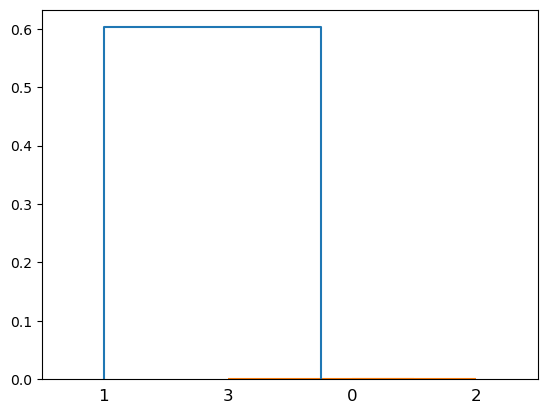

In [ ]:
dendrogram(cluster)

In [ ]:
fcluster(cluster, 0.5, criterion="distance")

array([1, 2, 1, 1], dtype=int32)

#### Summing intensities

In [ ]:
exp = fia_df.loc[0, "lim_experiment"]
exp.getSpectra()[0].get_peaks()[1][-50:]

array([ 61.,   0.,   0.,   0.,  58.,   0.,   0.,   3.,   0.,   0.,   0.,
         3.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   3.,   0.,   0.,
         0.,   3.,   0.,   0.,   0.,  49.,   0.,   0.,   0.,  52.,   0.,
         0.,   0.,  42.,   0.,   0.,   0., 263.,   0.,   0.,   0., 269.,
         0.,   0., 238.,   0.,   0.,   0.], dtype=float32)

In [ ]:
bins = np.linspace(1, 10, 100)
np.digitize(np.array([1,1.6,2,2,3,8,8,8,8,8,8]), bins)

array([ 1,  7, 12, 12, 23, 78, 78, 78, 78, 78, 78], dtype=int64)

In [ ]:
fia_df

,sample,polarity,experiment,lim_experiment
0,mg1655,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
1,mg1655,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
2,nissle,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
3,nissle,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
4,tue1,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
5,tue1,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._pyopenms_5.MSExperiment object at 0...
